In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import deepthought, mne, os

from deepthought.util.logging_util import configure_custom
configure_custom(debug=False)
mne.set_log_level('WARNING') # fewer log messages; for more change to INFO or DEBUG

### TODO: change this for each subject
subject = 'P01'

from deepthought.datasets.openmiir.metadata import get_stimuli_version
STIMULI_VERSION = get_stimuli_version(subject)

sfreq = 64.0

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
from deepthought.experiments.bcmi2015.preprocessing import load_and_preprocess_raw
raw, trial_events, beat_events = load_and_preprocess_raw(subject, sfreq=sfreq, verbose=False)

Loading raw data for subject "P01" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P01-raw.fif
Interpolating bad channels: [u'P8', u'P10', u'T8']
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 1, 3, 11]


mean: 37
median: 36
mode: 32
max: 34
best pair: 72.00 36.00
expected:  71.00 213.00


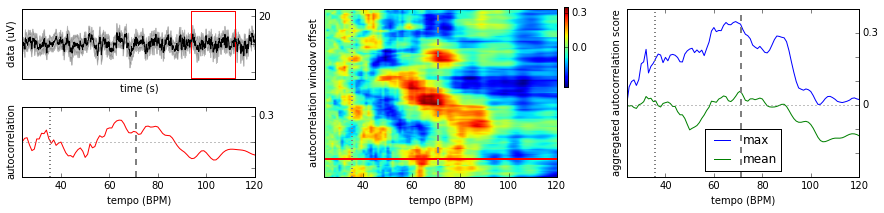

In [8]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from deepthought.experiments.bcmi2015.tempo_prediction import sliding_window_tempo_analysis
from deepthought.datasets.openmiir.epochs import get_trial_epochs
from deepthought.analysis.tempo.autocorrelation import *
from deepthought.datasets.openmiir.metadata import load_stimuli_metadata

meta = load_stimuli_metadata(version=STIMULI_VERSION)

def plot_sliding_window_tempo_analysis(stim_id, cond, tno, mode, verbose=False):
    
    HOP_SIZE = 5
    WINDOW_LENGTH = int(np.ceil(2.5*sfreq))
    # MAX_LENGTH = int(np.floor(6.8*sfreq)) # NOTE: shortest trial is 6.8709s
    MAX_LENGTH = int(np.floor(20*sfreq)) # NOTE: shortest trial is 6.8709s

    trials = get_trial_epochs(raw, trial_events, 
                              stim_id=stim_id, condition=cond, 
                              subject=subject, include_cue=False)

    if tno == 'all':
        trial = trials.get_data()
        trial = np.asarray(trial).mean(axis=1)
    else:
        trial = trials.get_data()[tno]
    trial = trial.squeeze()
#     print trial.shape
    
    title = '{} - {} - cond. {}, trial {} ({})'.format(stim_id, meta[stim_id]['label'], cond, tno, mode)
    
    # use measured values instead of imprecise approx_bar_length
    #     gt_bar_step = meta[stim_id]['approx_bar_length'] * sfreq
    #     gt_beat_step = gt_bar_step / meta[stim_id]['beats_per_bar']
    #     gt_bpm = meta[stim_id]['bpm'] / float(meta[stim_id]['beats_per_bar'])
    gt_beat_tempo = float(meta[stim_id]['bpm'])
    gt_bar_tempo = float(gt_beat_tempo) / meta[stim_id]['beats_per_bar']
        
    skip_samples = 0
    max_samples = trial.shape[-1]
    max_samples = min(max_samples, MAX_LENGTH) 
    
    x = np.arange(24, 121, 1)
#     x = np.arange(45, 161, 1)
    
    plot_step_idx = 620 # offset for red window in plot
    
    def add_markers(best=None):
        if best is not None:
            plt.axvline(x[best[0]], color='red', linestyle='--', linewidth=2)
            plt.axvline(x[best[1]], color='red', linestyle=':', linewidth=2)
        if gt_beat_tempo is not None:
            if gt_beat_tempo < x[-1]:
                plt.axvline(gt_beat_tempo, color='gray', linestyle='--', linewidth=1)
    #         add_marker_lines(gt_beat_step, window_length, 'gray', linestyle='--', linewidth=1)
        if gt_bar_tempo is not None:
            if gt_bar_tempo < x[-1]:
                plt.axvline(gt_bar_tempo, color='gray', linestyle='--', linewidth=2)
            if 0.5 * gt_bar_tempo > x[0]:
                plt.axvline(0.5 * gt_bar_tempo, color='gray', linestyle=':', linewidth=2)
            if 2 * gt_bar_tempo < x[-1]:
                plt.axvline(2 * gt_bar_tempo, color='gray', linestyle=':', linewidth=2)
    #         add_marker_lines(gt_bar_step, window_length, 'red', linestyle=':', linewidth=1)

    fig = plt.figure(figsize=(15,3))
    subplot_grid = gridspec.GridSpec(2, 3, height_ratios=[1,1])

    axes = plt.subplot(subplot_grid[0, 0])

    data = trial
    times = np.arange(0, data.shape[-1], 1) / sfreq
    uV_scaling = 1e6

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    hyp_limits = (mean - std, mean + std)                       # std

    axes.plot(times, uV_scaling * mean, color='black', linewidth=1)

    axes.set_xlim((times[0], times[-1]))
    axes.set_xlabel('time (s)')
    axes.set_ylabel('data (uV)')

    hyp_limits = uV_scaling * np.asarray(hyp_limits)
    axes.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='black', alpha=0.25)
    
    axes.yaxis.tick_right()
    axes.set_ylim((-25,25))
    axes.set_yticks([-20,0,20])
    axes.set_yticklabels(['', '', 20])
    plt.setp(axes.get_xticklabels(), visible=False)
    axes.set_xticks([])

    ## add sliding window
    ylim = axes.get_ylim()
    axes.add_patch(Rectangle(
                    (times[plot_step_idx], ylim[0]+1),
                    times[plot_step_idx+WINDOW_LENGTH] - times[plot_step_idx], 
                    ylim[1]-ylim[0]-2,
                    fill=False,
                    edgecolor='red', linewidth=1, linestyle='solid'))
    
    ## plot AC tempo curve of window
    window_data = trial.mean(axis=0)[plot_step_idx:plot_step_idx+WINDOW_LENGTH]
    ac = compute_autocorrelation(window_data)
    tempo_curve = compute_tempo_histogram_from_ac(ac, sfreq)
    y = tempo_curve(x)
    
    axes = plt.subplot(subplot_grid[1, 0])
    plt.xlabel('tempo (BPM)')
    plt.ylabel('autocorrelation')
    axes.yaxis.tick_right()
    axes.plot(x, y, color='red')
    plt.axhline(0, color='gray', linestyle=':', linewidth=1) # zero
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.4, 0.4))
    axes.set_yticks([-0.3, 0, 0.3])
    axes.set_yticklabels(['', '', 0.3])
    add_markers()
    
    best, im, best_pairs, best_scores = sliding_window_tempo_analysis(
        trial, sfreq, 
        min(x), max(x), 
        skip_samples, max_samples, 
        WINDOW_LENGTH, HOP_SIZE, 
        mode='median', verbose=verbose)
    
    im_mean = im.mean(axis=0)
    im_max = im.max(axis=0)

    if verbose:
        print 'best pair: {:.2f} {:.2f}'.format(*best)
        if gt_bar_tempo is not None:
            print 'expected:  {:.2f} {:.2f}'.format(gt_bar_tempo, gt_beat_tempo)

    
    axes = plt.subplot(subplot_grid[:, 1])
    axes.imshow(im, extent=[x[0],x[-1],len(im),0], aspect='auto') #, vmin=-1, vmax=1)
    plt.axhline(plot_step_idx / HOP_SIZE, color='red', linestyle='-', linewidth=2)
    plt.xlabel('tempo (BPM)')
    plt.ylabel('autocorrelation window offset')
    plt.yticks([])
    add_markers()
    
    cax = inset_axes(axes,
                 width="2%",
                 height="50%",
                 bbox_transform=axes.transAxes,
                 bbox_to_anchor=(0.025, 0.1, 1.05, 0.95),
                 loc= 1)
    norm = mpl.colors.Normalize(vmin=im.min(), vmax=im.max())
    cbar = mpl.colorbar.ColorbarBase(cax, 
                        cmap=matplotlib.cm.jet, norm=norm, 
                        orientation='vertical')
    cbar.set_ticks([0,0.3])

    axes = plt.subplot(subplot_grid[:, 2])
    plt.xlabel('tempo (BPM)')
    plt.ylabel('aggregated autocorrelation score')
    axes.plot(x, im_max, label='max')
    axes.plot(x, im_mean, label='mean')
    plt.xlim((x[0], x[-1]))
    plt.axhline(0, color='gray', linestyle=':', linewidth=1) # zero
    axes.yaxis.tick_right()
    add_markers()
    axes.set_yticks(np.arange(-0.3, 0.4, 0.1))
    axes.set_yticklabels(['','','',0,'','',0.3])
    axes.legend(loc='best')

    
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

    return fig

    
fig = plot_sliding_window_tempo_analysis(1,2,0, 'median', verbose=True)
# fig.savefig('plots/sliding-window-analysis.pdf', bbox_inches='tight')

Note: This graphic looks slightly different then in the paper even though it is the same trial. The reason for this is that the preprocessing pipeline has been updated in the meantime. Most notably, bad channels have been identified and the artifact removal using ICA has been improved significantly.  
(Arrows were added later.)